In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import SimpleITK as sitk
import torch
from monai.metrics import DiceMetric, SurfaceDistanceMetric
from monai.transforms import (
    AsDiscrete,
    Compose,
    EnsureChannelFirst,
    EnsureType,
    Lambda,
    LoadImage,
    Orientation,
    ToDevice,
    Transpose,
    LabelFilterd,
    MapLabelValued
    
    
)

from tqdm import tqdm
from lighter.utils.dynamic_imports import import_module_from_path
from pathlib import Path
from tqdm import tqdm
import torchmetrics
from totalsegmentator.map_to_binary import class_map

import_module_from_path("project", "/home/suraj/Repositories/lighter-ct-fm")
from project.data import get_ts_class_indices, get_ts_class_labels

2024/08/09 07:23:57.003  |  ℹ️  INFO      |  /home/suraj/Repositories/lighter-ct-fm imported   ]8;id=78507;file:///home/suraj/Repositories/lighter/lighter/utils/dynamic_imports.py\dynamic_imports.py]8;;\:]8;id=503203;file:///home/suraj/Repositories/lighter/lighter/utils/dynamic_imports.py#79\79]8;;\
as 'project' module.                                                                                               

In [2]:
label_map = class_map["total"]
pred_dir = Path("/mnt/data1/CT_FM/evaluations/totalseg/predictions")
dataset_path = Path("/mnt/data1/TotalSegmentator/v2/processed")

In [32]:
results = []
device = "cuda:0"
group_filter = [
    "merlin_V2"
]

for model_dir in pred_dir.glob("*"):
    group = "_".join(model_dir.name.split("_")[-2:])
    if group not in group_filter:
        continue

    group_map = {
        "quick_v2": "v2",
        "merlin_V2": "merlin_v2",
        "vista_v2": "v2"
    }

    if group in group_map:
        group = group_map[group]
    
    model_name = "_".join(model_dir.name.split("_")[:-2])

    print(f"Evaluating... Group: {group}, Model: {model_name}\n")
    class_indices = get_ts_class_indices(group=group)
    class_labels = get_ts_class_labels(class_indices, group=group)
    out_channels = len(class_indices)

    dice = DiceMetric(include_background=True, num_classes=out_channels, reduction="none")
    micro_dice = torchmetrics.Dice(ignore_index=0, num_classes=out_channels, compute_on_cpu=True).to(device)

    base_transforms = Compose([
        LoadImage(),
        ToDevice(device=device),
        EnsureChannelFirst(),
        EnsureType(data_type="tensor", dtype="int"),
        Orientation(axcodes="SPL" if "suprem" not in model_name else "RAS"),
    ])

    mapping_transforms = Compose([
        Lambda(lambda x: {"label": x}),
        LabelFilterd(keys="label", applied_labels=class_indices),
        MapLabelValued(keys="label", orig_labels=class_indices, target_labels=list(range(out_channels))),
        Lambda(lambda x: x["label"])
    ])

    target_transforms = Compose([base_transforms, mapping_transforms])

    print("Calculating Dice Scores... \n")
    dice_dict = {label: [] for label in class_labels}
    image_samples = []
    preds_list = list(model_dir.glob("*"))
    for pred_path in tqdm(preds_list):
        sid = pred_path.stem.split(".")[0]
        label = target_transforms(dataset_path / sid / "label.nii.gz").unsqueeze(0)
        image = base_transforms(dataset_path / sid / "ct.nii.gz").unsqueeze(0)
        pred = base_transforms(pred_path).unsqueeze(0)

        res = dice(pred, label).squeeze().tolist()
        # micro_dice.update(pred, label.squeeze(1).long())
        for label_name, score in zip(class_labels, res):
            dice_dict[label_name].append(score)
        
        if len(image_samples) < 5:
            image_samples.append({
                "sid": sid,
                "label": label,
                "image": image,
                "pred": pred
            })


    dice_dict.pop("background", None)
    class_aggregate_dict = {k: np.nanmean(v) for k, v in dice_dict.items()}
    overall_dice = micro_dice.compute()
    overall_dice = None

    class_aggregate_dice = np.nanmean(list(class_aggregate_dict.values()))
    results.append({"group": group, "model": model_name, "all_scores": dice_dict, "class_dice_scores": dice_dict, "overall_dice": overall_dice, "class_aggregate_dice": class_aggregate_dice, "image_samples": image_samples})


Evaluating... Group: merlin_v2, Model: baseline

Number of classes: 21
Calculating Dice Scores... 



  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:39<00:00,  1.16s/it]


2024/08/09 07:43:35.983  |  ⚠️  WARNING   |  The ``compute`` method of metric Dice was called before    ]8;id=984382;file:///home/suraj/miniconda3/envs/lighter_dev/lib/python3.10/site-packages/torchmetrics/utilities/prints.py\prints.py]8;;\:]8;id=618428;file:///home/suraj/miniconda3/envs/lighter_dev/lib/python3.10/site-packages/torchmetrics/utilities/prints.py#43\43]8;;\
the ``update`` method which may lead to errors, as metric states have not yet been updated.                        

Evaluating... Group: merlin_v2, Model: ct_fm

Number of classes: 21
Calculating Dice Scores... 



100%|██████████| 34/34 [00:39<00:00,  1.15s/it]


In [43]:
# Convert the data into a pandas DataFrame
rows = []
for entry in results:
    for organ, dice_scores in entry['all_scores'].items():
        rows.append({
            'Model': entry['model'],
            'Group': entry['group'],
            'Organ': organ,
            'Dice Score': np.nanmean(dice_scores),
            'Overall Dice': entry['overall_dice'],
            'Macro Dice': entry['class_aggregate_dice']
        })


rows.append({"Group": "merlin_v2", "Model": "Merlin", "Macro Dice": 0.86})
df = pd.DataFrame(rows)
    
# Per class Dice Score comparison
fig_per_class = px.bar(df, x='Organ', y='Dice Score', color='Model', title='Per Class Dice Score Comparison',
                        barmode='group', template='plotly_white', color_discrete_sequence=px.colors.qualitative.Set1)
fig_per_class.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black')
)
fig_per_class.show()

# Overall Dice Score comparison
fig = px.bar(df[["Model", "Macro Dice", "Group"]].drop_duplicates(), x='Group', y='Macro Dice', color='Model', title='Overall Dice Comparison', barmode='group', height=600, width=400, template='plotly_white', color_discrete_sequence=px.colors.qualitative.Plotly, range_y=[0.7, 0.9])
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black')
)
fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
fig.show()

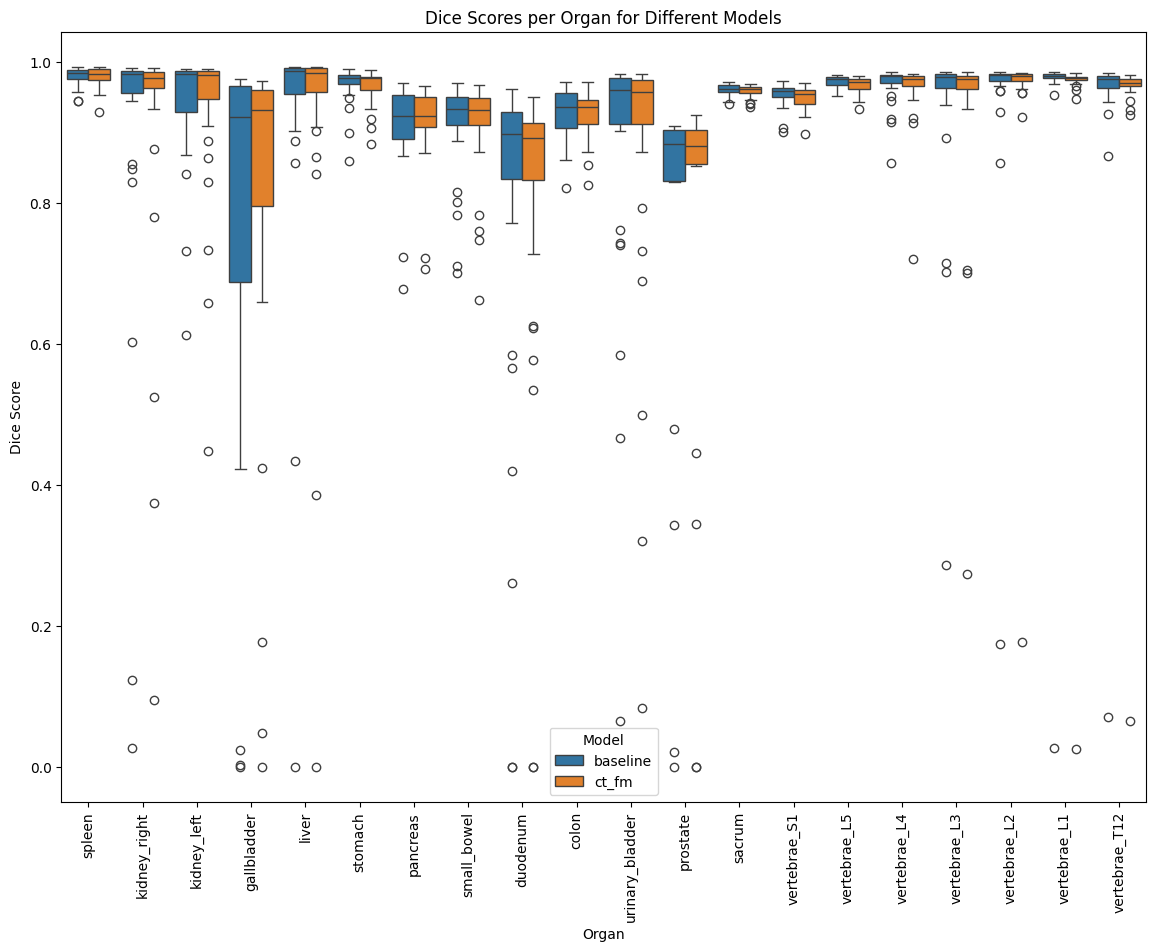

In [44]:
import matplotlib.pyplot as plt

# Prepare data for plotting
plot_data = []
for result in results:
    model_name = result["model"]
    for organ, scores in result["all_scores"].items():
        for score in scores:
            plot_data.append({"Model": model_name, "Organ": organ, "Score": score})

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Plot box plot
plt.figure(figsize=(14, 10))
sns.boxplot(data=plot_df, x="Organ", y="Score", hue="Model")
plt.title('Dice Scores per Organ for Different Models')
plt.xlabel('Organ')
plt.ylabel('Dice Score')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.show()

In [17]:
import matplotlib.pyplot as plt

def plot_3d_image(ret):
    # Plot axial slice
    ensure_list = lambda x: x if isinstance(x, list) else [x]
    ret = ensure_list(ret)
    
    plt.figure(figsize=(10, 10))
    for i in range(len(ret)):
        plt.subplot(len(ret), 3, i * 3 + 1)
        plt.imshow(ret[i][:, ret[i].shape[1] // 2, :, :].permute(1, 2, 0), cmap="gray")
        plt.title("Axial")
        plt.axis("off")

    for i in range(len(ret)):
        plt.subplot(len(ret), 3, i * 3 + 2)
        plt.imshow(ret[i][:, :, ret[i].shape[2] // 2, :].permute(1, 2, 0), cmap="gray")
        plt.title("Coronal")
        plt.axis("off")
        
    for i in range(len(ret)):
        plt.subplot(len(ret), 3, i * 3 + 3)
        plt.imshow(ret[i][:, :, :, ret[i].shape[3] // 2].permute(1, 2, 0), cmap="gray")
        plt.title("Sagittal")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
                

v2 ct_fm None


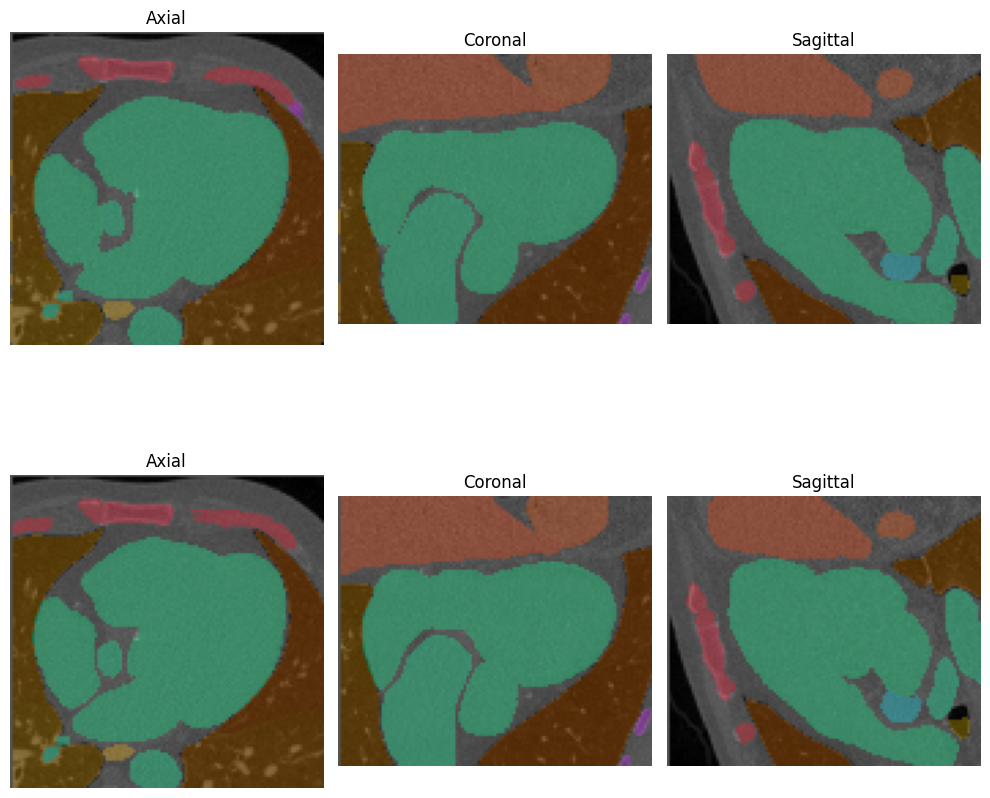

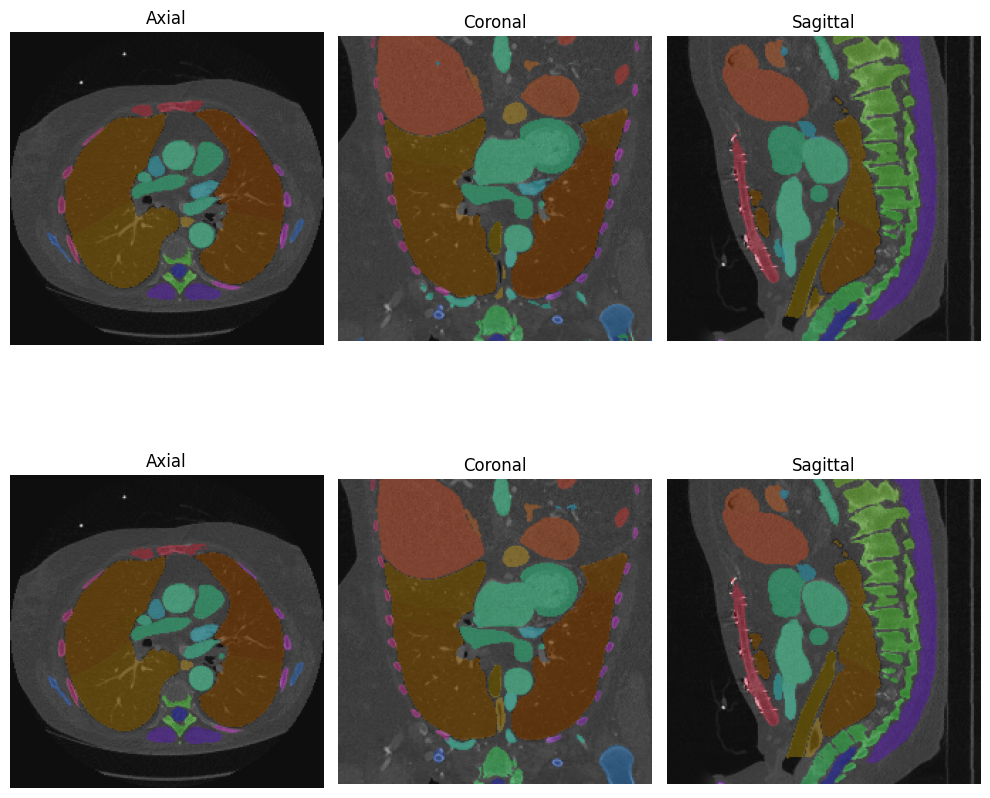

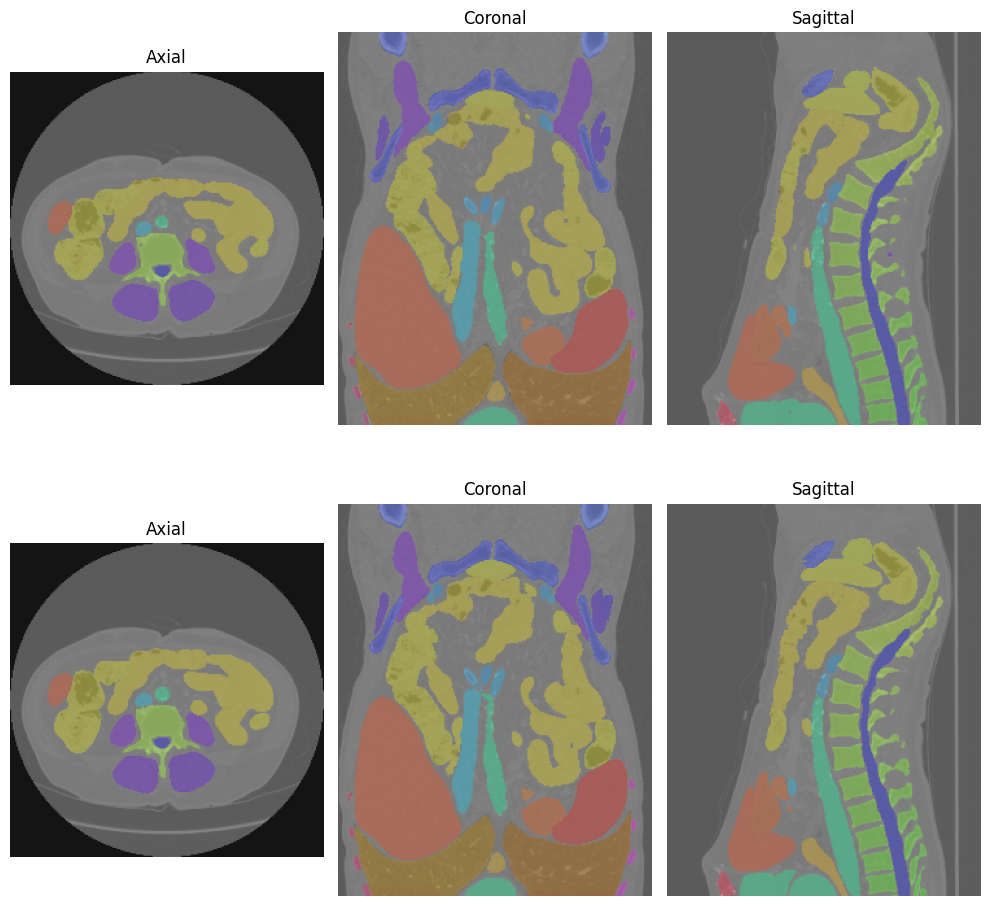

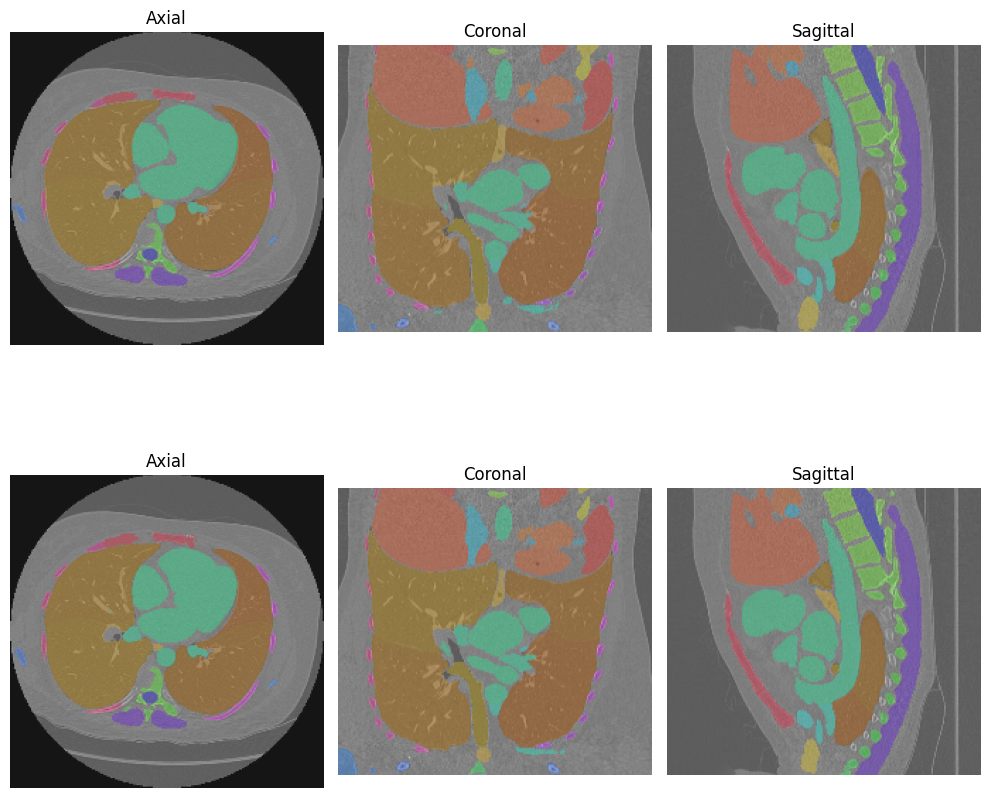

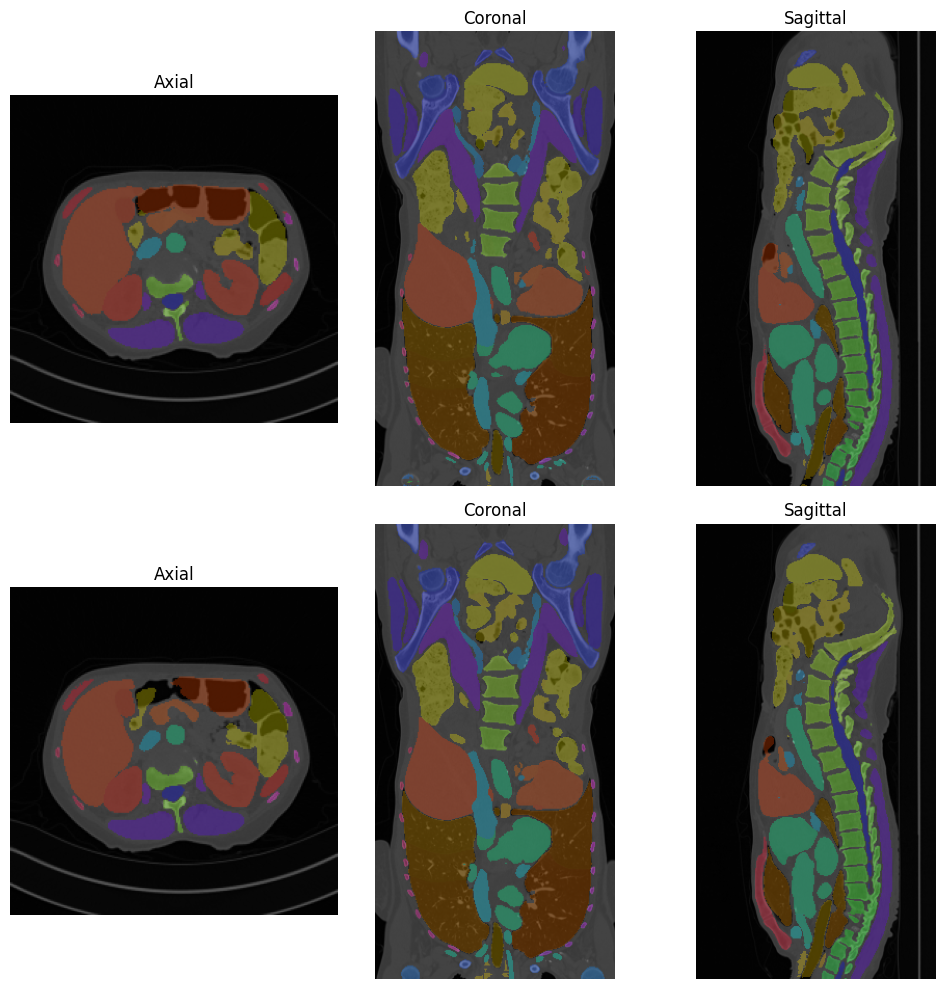

: 

In [18]:
from monai.visualize import blend_images

for result in results:
    print(result["group"], result["model"], result["overall_dice"])

    for sample in result["image_samples"]:
        image = sample["image"].squeeze(0).cpu()
        label = sample["label"].squeeze(0).cpu()
        pred = sample["pred"].squeeze(0).cpu()
        sid = sample["sid"]
        
        label_max = out_channels - 1

        label = label / label_max
        pred = pred / label_max

        image = (image - image.min()) / (image.max() - image.min())
        
        ret_pred = blend_images(image=image, label=pred, alpha=0.3, cmap="hsv", rescale_arrays=False)
        ret_label = blend_images(image=image, label=label, alpha=0.3, cmap="hsv", rescale_arrays=False)
        plot_3d_image([ret_pred, ret_label])

